In [2]:
import kymatio
from kymatio.numpy import Scattering1D
import numpy as np
import time
import librosa
import matplotlib.pyplot as plt

In [3]:
# Load data
filename = "/home/hugo/Thèse/identification/data/tchai/A-Clara-tchai-1.wav"
x, sr = librosa.load(filename, sr=10000)
n = int(np.log2(len(x)))
shape = 2**n
print(f'Input shape : {shape}')
x = x[:shape]

import IPython
IPython.display.Audio(x, rate=sr)

Input shape : 131072


In [ ]:
kwargs = {
    'J': 6,
    'shape': shape,
    'Q': (8, 2),
    'T': 'global'
}
sc = Scattering1D(**kwargs)
Sx = sc(x)
print(f'Scattering shape : {Sx.shape}')

Scattering shape : (250, 1)


In [ ]:
meta = sc.meta()
idx_S0 = np.where(meta['order'] == 0)
idx_S1 = np.where(meta['order'] == 1)[0]
idx_S2 = np.where(meta['order'] == 2)[0]
idx_S1S2 = np.where(meta['order'] != 0)[0]

54
411


In [199]:
Sx[idx_S2].shape

(411, 1024)

In [195]:
xi1s = np.array([sr * psi['xi'] for psi in sc.psi1_f])
xi2s = np.array([sr * psi['xi'] for psi in sc.psi2_f])

sigma1s = [sr * psi['sigma'] for psi in sc.psi1_f]
sigma2s = [sr * psi['sigma'] for psi in sc.psi2_f]

mid_xi1s = np.sqrt(xi1s[1:] * xi1s[:-1])  # center for two valuess in a log scale
mid_xi2s = np.sqrt(xi2s[1:] * xi2s[:-1])
x_coords = np.array([sr//2] + list(mid_xi2s) + [xi2s[-1]-sigma2s[-1]])
y_coords = np.array([sr//2] + list(mid_xi1s) + [xi1s[-1]-sigma1s[-1]])

print(idx_S1.shape)
print(y_coords.shape)

x_coords = np.hstack((x_coords, x_coords[-1] / 2))

(54,)
(55,)


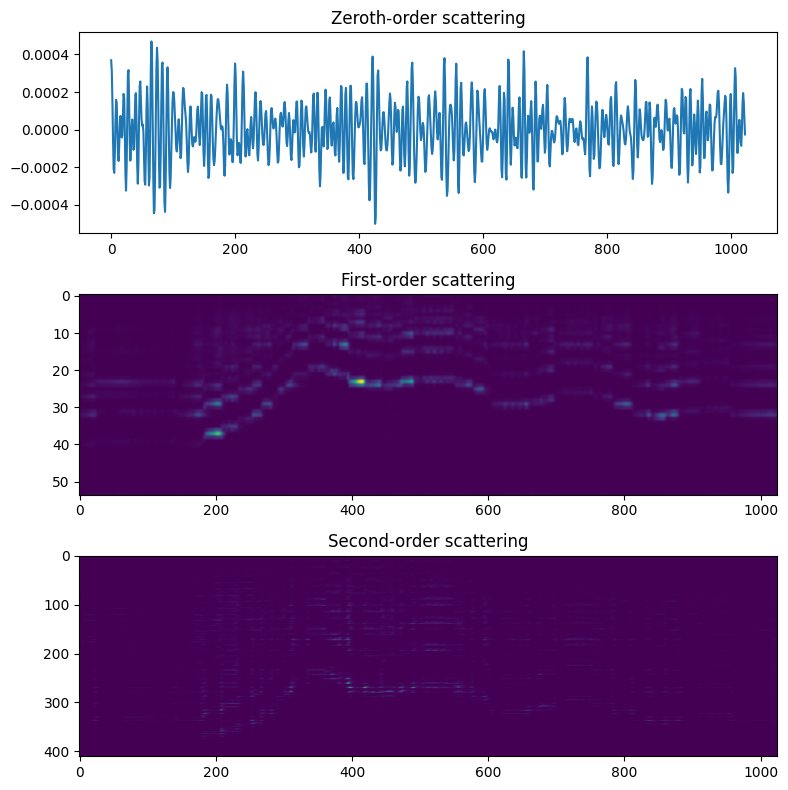

In [188]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[idx_S0][0])
plt.title('Zeroth-order scattering')
plt.subplot(3, 1, 2)
plt.imshow(Sx[idx_S1], aspect='auto')
plt.title('First-order scattering')
plt.subplot(3, 1, 3)
plt.imshow(Sx[idx_S2], aspect='auto')
plt.title('Second-order scattering')
plt.tight_layout()
plt.show()

In [ ]:
input_all = Sx[1:]
input_all = input_all.squeeze().mean(-1)
print(input_all.shape)

input_S2 = input_all[len(idx_S1):]

Sx2 = [{'coef': input_S2[k], 'n': meta['n'][idx_S2[k],:].astype(int)} for k in range(input_S2.shape[-1])]
input_feature = np.zeros((len(xi1s), 1+len(xi2s))) * np.nan

input_feature[:len(idx_S1), -1] = input_all[:len(idx_S1)]

for path in Sx2:
    n1 = path['n'][0]
    xi1 = xi1s[n1]
    n2 = path['n'][1]
    xi2 = xi2s[n2]
    input_feature[n1, n2] = path['coef'] # / (xi1*xi2)


(465,)


(np.float64(4.608980419227854), np.float64(1664.889961003809))

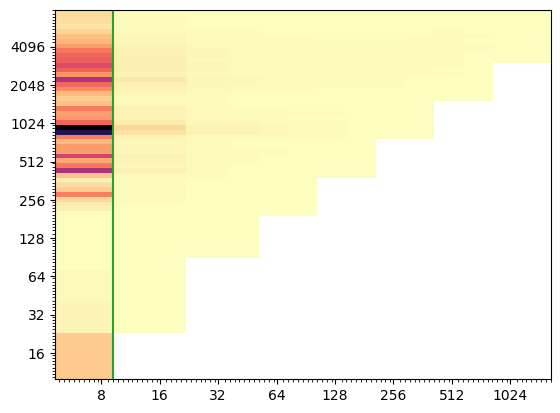

In [192]:
from librosa.display import specshow

fig, ax = plt.subplots(1, 1)

specshow(
        input_feature, x_coords=x_coords, y_coords=y_coords,
        x_axis='cqt_hz', y_axis='cqt_hz', cmap='magma_r')
x_ticklabels = list((lambda n: 8 ** n)(np.arange(5)))
# y_ticklabels = (lambda n: freq_min * 4 ** n)(np.arange(5))
xpos_forS1 = np.sqrt(x_coords[-1] * x_coords[-2])
max_xi2s = x_coords[np.where(np.isnan(input_feature[0,:]))[0][-1] + 1]
# ax.set_ylim(bottom=min(y_coords[y_coords >= freq_min]), top=max(y_coords))
ax.axvline(x=x_coords[-2], color='tab:green')   
ax.set(xlabel=None, ylabel=None)
# ax.set_ylim(bottom=freq_min, top=max(y_coords))
# ax.set_yticks(y_ticklabels)
# ax.set_yticklabels(y_ticklabels)
ax.set_xlim(right=max_xi2s)